In [1]:
import glob
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import numpy as np

/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/vladimirk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Lab validation AMP Tox G+ G-

ESM2 G-: {0: 8849, 1: 3871}
ESM3 amp: {1: 7054, 0: 5666}
PTRANS amp: {1: 6848, 0: 5872}
ESM2 tox: {1: 3353, 0: 9367}
ESM3 G+: {1: 4198, 0: 8522}
ESM3 G-: {1: 3969, 0: 8751}
PTRANS G+: {0: 8282, 1: 4438}
PTRANS G-: {0: 8644, 1: 4076}
ESM2 amp: {1: 6308, 0: 6412}
PTRANS tox: {1: 1885, 0: 10835}
ESM2 G+: {0: 8820, 1: 3900}
ESM3 tox: {1: 2116, 0: 10604}
Top 30% (3816 peptides) in ESM3 amp
AMP active and non-toxic predicted by ESM2 and ESM3: 2153
AMP active and non-toxic predicted by ESM2 and ESM3 within top 30.0% (3816 peptides from each): 52


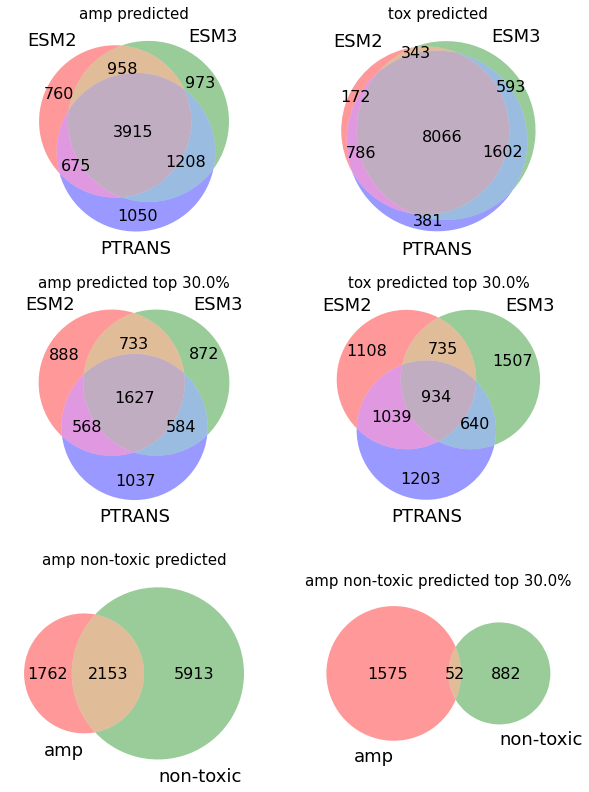

------------------------------------------------------------------------------------------
Top 30% (3816 peptides) in ESM3 G+
AMP active and non-toxic predicted by ESM2 and ESM3: 975
AMP active and non-toxic predicted by ESM2 and ESM3 within top 30.0% (3816 peptides from each): 66


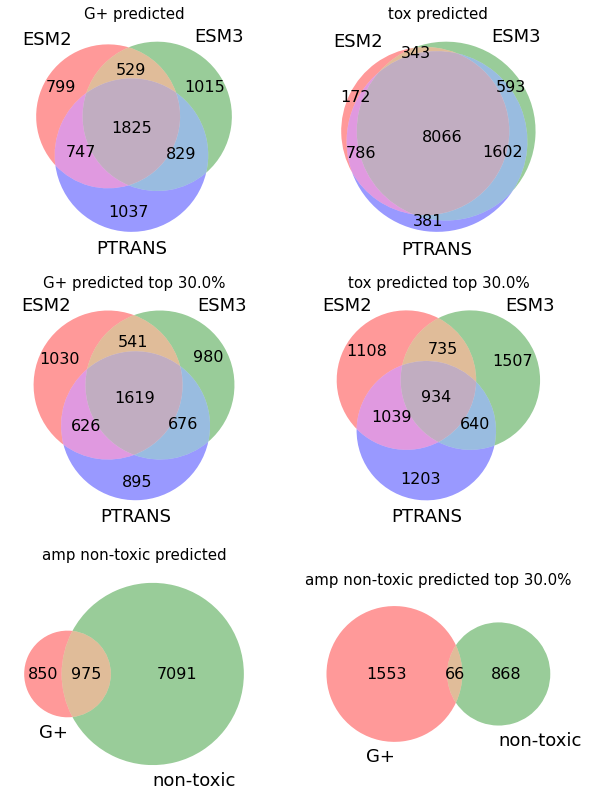

------------------------------------------------------------------------------------------
Top 30% (3816 peptides) in ESM3 G-
AMP active and non-toxic predicted by ESM2 and ESM3: 915
AMP active and non-toxic predicted by ESM2 and ESM3 within top 30.0% (3816 peptides from each): 57


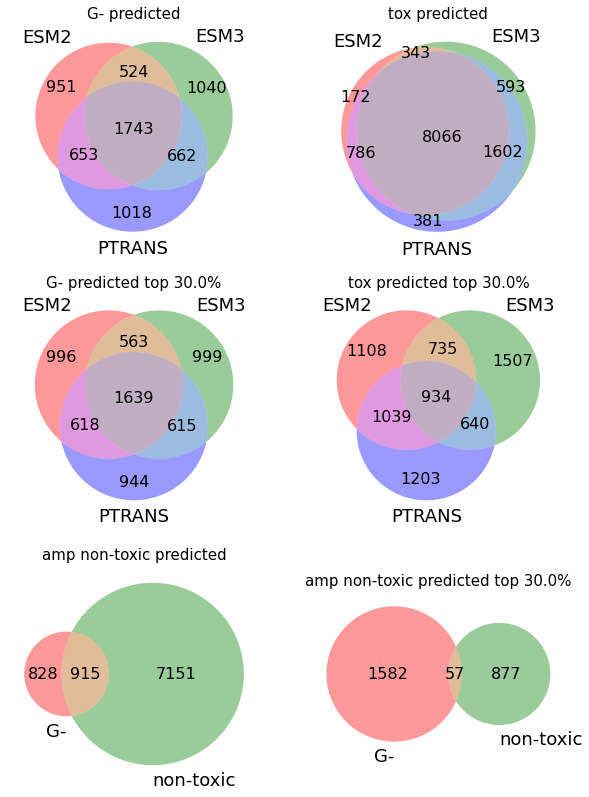

------------------------------------------------------------------------------------------


In [12]:
# Get data file names
path = '../data/predictions/ripp_lab_validation/'
filenames = glob.glob(path + "*.tsv")

dfs_raw = {'ESM2': dict(), 'ESM3': dict(), 'PTRANS': dict()}
dfs = {'ESM2': dict(), 'ESM3': dict(), 'PTRANS': dict()}
sets = {'ESM2': dict(), 'ESM3': dict(), 'PTRANS': dict()}

top_perc = 0.30

dfs_top_perc = {'ESM2': dict(), 'ESM3': dict(), 'PTRANS': dict()}
sets_top_perc = {'ESM2': dict(), 'ESM3': dict(), 'PTRANS': dict()}
for filename in filenames:
    model = os.path.basename(filename).split('_')[0]
    ds = os.path.basename(filename).split('_')[1]
    df = pd.read_csv(filename, sep='\t')
    size_top_perc = int(len(df) * top_perc)
    dfs_raw[model][ds] = df.copy()
    if ds == 'tox':
        df = df[df['prediction'] == 0]  # Keep only non-toxic
    else:
        df = df[df['prediction'] == 1]  # Keep only AMP active
    dfs[model][ds] = df
    sets[model][ds] = set(df['protein_id'].values)
    
    df = df.sort_values(by='probability', ascending=False)
    df = df.iloc[:size_top_perc, :]
    
    dfs_top_perc[model][ds] = df
    sets_top_perc[model][ds] = set(df['protein_id'].values)
    
    cnt = Counter(dfs_raw[model][ds]['prediction'])
    print(f'{model} {ds}: {dict(cnt)}')
    
for amp_ds in ['amp', 'G+', 'G-']:
    for_lab = set(dfs_raw['ESM2']['tox']['protein_id'].values)  # Get all protein IDs
    for_lab_top_perc = for_lab.copy()
    for ds in ['tox', amp_ds]:
        for_lab = for_lab.intersection(sets['ESM2'][ds].intersection(sets['ESM3'][ds]).intersection(sets['PTRANS'][ds]))
        for_lab_top_perc = for_lab_top_perc.intersection(sets_top_perc['ESM2'][ds].intersection(sets_top_perc['ESM3'][ds]).intersection(sets_top_perc['PTRANS'][ds]))

    print(f'Top {int(top_perc * 100)}% ({len(sets_top_perc[model][ds])} peptides) in {model} {ds}')
    print(f'AMP active and non-toxic predicted by ESM2 and ESM3: {len(for_lab)}')
    print(f'AMP active and non-toxic predicted by ESM2 and ESM3 within top {top_perc * 100}% ({len(sets_top_perc[model][ds])} peptides from each): {len(for_lab_top_perc)}')
    
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))
    for ind_st, st in enumerate([sets, sets_top_perc]):     
        for ind, ds in enumerate([amp_ds, 'tox']):
#             venn = venn2([st['ESM2'][ds], st['ESM3'][ds]], set_labels=tuple(st.keys()), ax=axs[ind_st][ind])
            venn = venn3([st['ESM2'][ds], st['ESM3'][ds], st['PTRANS'][ds]], set_labels=tuple(st.keys()), ax=axs[ind_st][ind])

            for text in venn.set_labels:
                text.set_fontsize(18)
            for text in venn.subset_labels:
                text.set_fontsize(16)
            axs[ind_st][ind].set_title(f"{ds} predicted" + (f' top {top_perc*100}%' if ind_st > 0 else ''), size=15)


    for ind, st in enumerate([sets, sets_top_perc]): 
#         venn = venn2([st['ESM2']['amp'].intersection(st['ESM3']['amp']), 
#                       st['ESM2']['tox'].intersection(st['ESM3']['tox'])], set_labels=tuple([amp_ds, 'non-toxic']), ax=axs[2][ind])
        venn = venn2([st['ESM2'][amp_ds].intersection(st['ESM3'][amp_ds]).intersection(st['PTRANS'][amp_ds]), 
                      st['ESM2']['tox'].intersection(st['ESM3']['tox']).intersection(st['PTRANS']['tox'])], set_labels=tuple([amp_ds, 'non-toxic']), ax=axs[2][ind])

        for text in venn.set_labels:
            text.set_fontsize(18)
        for text in venn.subset_labels:
            text.set_fontsize(16)
        axs[2][ind].set_title(f"amp non-toxic predicted" + (f' top {top_perc*100}%' if ind > 0 else ''), size=15)

#     plt.savefig(f'{amp_ds}_tox_ripp_venn.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    #Save results
    orig_df = pd.read_csv('../data/ripp_corepep.tsv', sep='\t', header=None)
    for_lab_df = orig_df[ orig_df[0].isin(for_lab_top_perc)]  # Labels (column 3) given here are random! Ignore them!
    for_lab_df.to_csv(f'lab_validation_{amp_ds}.tsv', sep='\t', index=False, header=False)
    print('-' * 90)


# AMP Toxicity RIPP

In [61]:
# Get data file names
path = '../data/predictions/amp_ripp/'
filenames = glob.glob(path + "*.tsv")

dfs_raw = {'esm2': dict(), 'esm3': dict()}
dfs = {'esm2': dict(), 'esm3': dict()}
sets = {'esm2': dict(), 'esm3': dict()}

top_perc = 0.20

dfs_top_perc = {'esm2': dict(), 'esm3': dict()}
sets_top_perc = {'esm2': dict(), 'esm3': dict()}
for filename in filenames:
    model = os.path.basename(filename).split('_')[0]
    ds = os.path.basename(filename).split('_')[1]
    df = pd.read_csv(filename, sep='\t')
    size_top_perc = int(len(df) * top_perc)
    dfs_raw[model][ds] = df.copy()
    if ds == 'tox':
        df = df[df['prediction'] == 0]  # Keep only non-toxic
    else:
        df = df[df['prediction'] == 1]  # Keep only AMP active
    dfs[model][ds] = df
    sets[model][ds] = set(df['protein_id'].values)
    
    df = df.sort_values(by='probability', ascending=False)
    df = df.iloc[:size_top_perc, :]
    
    dfs_top_perc[model][ds] = df
    sets_top_perc[model][ds] = set(df['protein_id'].values)
    
    cnt = Counter(dfs_raw[model][ds]['prediction'])
    print(f'{model} {ds}: {dict(cnt)}')
    
for_lab = set(dfs_raw['esm2']['tox']['protein_id'].values)  # Get all protein IDs
for_lab_top_perc = for_lab.copy()
for ds in ['tox', 'amp']:
    for_lab = for_lab.intersection(sets['esm2'][ds].intersection(sets['esm3'][ds]))
    for_lab_top_perc = for_lab_top_perc.intersection(sets_top_perc['esm2'][ds].intersection(sets_top_perc['esm3'][ds]))
        
print(f'Top {int(top_perc * 100)}% ({len(sets_top_perc[model][ds])} peptides) in {model} {ds}')
print(f'AMP active and non-toxic predicted by ESM2 and ESM3: {len(for_lab)}')
print(f'AMP active and non-toxic predicted by ESM2 and ESM3 within top {top_perc * 100}% ({len(sets_1top_perc[model][ds])} peptides from each): {len(for_lab_top_perc)}')

esm2 tox: {0: 9908, 1: 2812}
esm3 tox: {0: 9740, 1: 2980}
esm3 amp: {1: 6813, 0: 5907}
esm2 amp: {1: 6260, 0: 6460}
Top 20% (2544 peptides) in esm2 amp
AMP active and non-toxic predicted by ESM2 and ESM3: 3095
AMP active and non-toxic predicted by ESM2 and ESM3 within top 20.0% (1272 peptides from each): 38


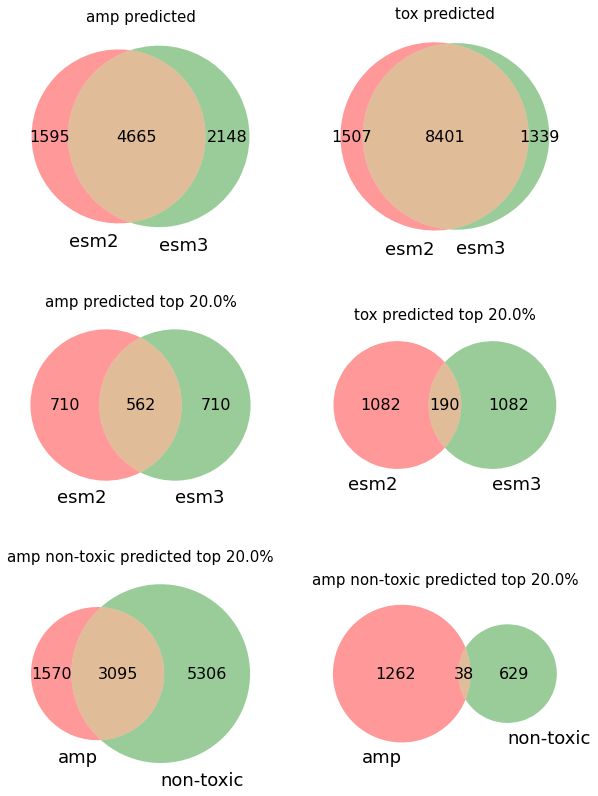

In [62]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))
for ind_st, st in enumerate([sets, sets_1top_perc]):     
    for ind, ds in enumerate(['amp', 'tox']):
        venn = venn2([st['esm2'][ds], st['esm3'][ds]], set_labels=tuple(st.keys()), ax=axs[ind_st][ind])
        for text in venn.set_labels:
            text.set_fontsize(18)
        for text in venn.subset_labels:
            text.set_fontsize(16)
        axs[ind_st][ind].set_title(f"{ds} predicted" + (f' top {top_perc*100}%' if ind_st > 0 else ''), size=15)
   

for ind, st in enumerate([sets, sets_top_perc]): 
    venn = venn2([st['esm2']['amp'].intersection(st['esm3']['amp']), 
                  st['esm2']['tox'].intersection(st['esm3']['tox'])], set_labels=tuple(['amp', 'non-toxic']), ax=axs[2][ind])
    for text in venn.set_labels:
        text.set_fontsize(18)
    for text in venn.subset_labels:
        text.set_fontsize(16)
    axs[2][ind].set_title(f"amp non-toxic predicted" + (f' top {top_perc*100}%' if ind_st > 0 else ''), size=15)

plt.savefig('amp_tox_ripp_venn.png', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
orig_df = pd.read_csv('../data/ripp_corepep.tsv', sep='\t', header=None)
for_lab_df = orig_df[ orig_df[0].isin(for_lab_top_perc)]  # Labels (column 3) given here are random! Ignore them!
for_lab_df.to_csv('amp_non_toxic.tsv', sep='\t', index=False, header=False)
for_lab_df

,0,1,2,3
5882,SRR23617280.bin.29_k141_328097.region001-gene2,11,SSAVASSAVTV,1
5975,SRR23823798.bin.10_k141_178736.region001-gene20,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,0
6050,SRR23823802.bin.23_k141_58835.region001-gene16,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,1
6083,SRR23823804.bin.7_k141_13186.region001-gene5,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,0
6219,SRR23823813.bin.7_k141_39352.region001-gene5,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,1
6230,SRR23823814.bin.25_k141_83051.region001-gene18,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,1
6433,SRR23823830.bin.42_k141_99872.region001-gene17,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,0
6457,SRR23823832.bin.11_k141_27281.region001-gene20,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,1
6472,SRR23823834.bin.20_k141_26932.region001-gene9,22,SGVSSAVAGVIIDSIPGPAIPG,1
6541,SRR23823841.bin.19_k141_72094.region001-gene5,31,GVVENGVFTKVDKVLVGNPKKVKTLKNKNKK,0
